In [1]:
from langchain_openai import ChatOpenAI
import os

In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="dotenv.txt");

In [3]:
MODEL_NAME = os.getenv('MISTRAL_SMALL_24B_QUANT_MODEL_NAME')
MODEL_API_KEY = os.getenv('MISTRAL_SMALL_24B_QUANT_API_KEY')
MODEL_BASE_URL = os.getenv('MISTRAL_SMALL_24B_QUANT_BASE_URL')

In [4]:
llm = ChatOpenAI(model=MODEL_NAME,
                 openai_api_key = MODEL_API_KEY,
                 openai_api_base = f"{MODEL_BASE_URL}/v1")

In [5]:
%run tool_list_operators-v2.ipynb

Loaded in-cluster configuration


In [6]:
%run tool_summarize_states-v2.ipynb

In [7]:
%run tool_prometheus-v2.ipynb

In [8]:
%run tool_mlasp-v2.ipynb

/opt/app-root/lib64/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
%run tool_rag-v2.ipynb

In [10]:
tools = [tool_list_openshift_operators, tool_query_prometheus_metrics, tool_get_prometheus_metric_data_range, 
         tool_plot_prometheus_metric_data_range_as_file, tool_calculate_time_information,
         tool_summarize_pod_states, tool_summarize_service_states,
         tool_wiremock_configuration_predictor, tool_retriever
        ]

In [11]:
type(tools)

list

In [12]:
type(tool_list_openshift_operators)

function

In [13]:
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [14]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using tools to retrieve information to answer questions about OpenShift, the services and applications running inside it.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

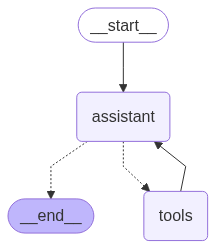

In [15]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [16]:
messages = [HumanMessage(content="hi, who are you?")]
messages = react_graph.invoke({"messages": messages})

In [17]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

hi, who are you?
================================== Ai Message ==================================

Hello! I'm an assistants that can help you with information and tasks related to OpenShift and the services and applications running inside it. I can use tools to retrieve specific details and answer your questions. Feel free to ask!


In [18]:
messages=[HumanMessage(content="What operators are in namespace demo?")]

In [19]:
messages = react_graph.invoke({"messages": messages})

In [20]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What operators are in namespace demo?
================================== Ai Message ==================================
Tool Calls:
  tool_list_openshift_operators (kpuBuqjqy)
 Call ID: kpuBuqjqy
  Args:
    namespace: demo
================================= Tool Message =================================
Name: tool_list_openshift_operators

[{"name": "authorino-operator", "namespace": "demo", "version": "1.2.2", "status": "Succeeded"}, {"name": "kiali-operator", "namespace": "demo", "version": "2.11.3", "status": "Succeeded"}, {"name": "openshift-pipelines-operator-rh", "namespace": "demo", "version": "1.19.3", "status": "Succeeded"}, {"name": "prometheusoperator", "namespace": "demo", "version": "0.56.3", "status": "Succeeded"}, {"name": "rhods-operator", "namespace": "demo", "version": "2.22.1", "status": "Succeeded"}, {"name": "serverless-operator", "namespace": "demo", "version": "1.36.0", "status": "Su

In [21]:
messages["messages"][-1].pretty_print()

================================== Ai Message ==================================

 The operators in the demo namespace are:

1. **authorino-operator** - Version 1.2.2 (Status: Succeeded)
2. **kiali-operator** - Version 2.11.3 (Status: Succeeded)
3. **openshift-pipelines-operator-rh** - Version 1.19.3 (Status: Succeeded)
4. **prometheusoperator** - Version 0.56.3 (Status: Succeeded)
5. **rhods-operator** - Version 2.22.1 (Status: Succeeded)
6. **serverless-operator** - Version 1.36.0 (Status: Succeeded)
7. **servicemeshoperator** - Version 2.6.10-0 (Status: Succeeded)
8. **tempo-operator** - Version 0.16.0-2 (Status: Succeeded)


In [25]:
messages=[HumanMessage(content="What configuration of WireMock supports a throughput KPI of 307 within a 2.9 percent precision? Search for 100 epochs to find the result.")]

In [26]:
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

/opt/app-root/lib64/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlasp-mlasp-datascience.apps.cluster-nr48j.nr48j.sandbox1693.opentlc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/opt/app-root/lib64/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlasp-mlasp-datascience.apps.cluster-nr48j.nr48j.sandbox1693.opentlc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/opt/app-root/lib64/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlasp-mlasp-datascience.apps.cluster-nr48j.nr48j.sandbox1693.opentlc.com'. Adding certificate verificatio

================================ Human Message =================================

What configuration of WireMock supports a throughput KPI of 307 within a 2.9 percent precision? Search for 100 epochs to find the result.
================================== Ai Message ==================================
Tool Calls:
  tool_wiremock_configuration_predictor (8BkyrVWPE)
 Call ID: 8BkyrVWPE
  Args:
    epochs: 100
    KPI_value: 307
    precision: 2.9
================================= Tool Message =================================
Name: tool_wiremock_configuration_predictor

{"Parameters": {"asyncResp": 0, "asyncRespThreads": 16, "cThreads": 108, "jacptQSize": 1776, "jacptThreads": 230, "ltTargetSize": 14, "numConnections": 32, "timeoutSeconds": 3}, "Deviation": 0.8508313642288079, "Prediction": 309.61205228818244}
================================== Ai Message ==================================

 WireMock with these configuration parameters supports a throughput KPI of approximately 309.61 with

In [27]:
messages["messages"][-1].pretty_print()

================================== Ai Message ==================================

 WireMock with these configuration parameters supports a throughput KPI of approximately 309.61 within a 2.9 percent precision.

 - asyncResp: 0
 - asyncRespThreads: 16
 - cThreads: 108
 - jacptQSize: 1776
 - jacptThreads: 230
 - ltTargetSize: 14
 - numConnections: 32
 - timeoutSeconds: 3


In [22]:
messages=[HumanMessage(content="Find out the Prometheus service name and port number running in namespace demo. Use it to to plot all the prometheus metric data for the metric load_generator_total_msg starting 48 hours ago until now. You must calculate the two timestamps before retrieving the metrics. Return only the filename provided by the tool and nothing else.")]

In [23]:
messages = react_graph.invoke({"messages": messages})

In [24]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Find out the Prometheus service name and port number running in namespace demo. Use it to to plot all the prometheus metric data for the metric load_generator_total_msg starting 48 hours ago until now. You must calculate the two timestamps before retrieving the metrics. Return only the content string of the tool and nothing else.
================================== Ai Message ==================================
Tool Calls:
  tool_calculate_time_information (E8TGa30fr)
 Call ID: E8TGa30fr
  Args:
    time_value: 48
    time_metric: hours
    ago_flag: 1
  tool_calculate_time_information (pWgyP6v8L)
 Call ID: pWgyP6v8L
  Args:
    time_value: now
    time_metric: seconds
    ago_flag: 0
  tool_summarize_service_states (9WSRJjeUj)
 Call ID: 9WSRJjeUj
  Args:
    namespace: demo
================================= Tool Message =================================
Name: tool_calculate_time_information

{"timestamp": 

In [25]:
messages["messages"][-1].pretty_print()

================================== Ai Message ==================================

 FILE-plot-load_generator_total_msg-1757973323-1758146123.png


In [35]:
messages=[HumanMessage(content="I want a short step by step summary on how to create a Data Science Project in OpenShift AI")]

In [36]:
messages = react_graph.invoke({"messages": messages})

In [37]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I want a short step by step summary on how to create a Data Science Project in OpenShift AI
================================== Ai Message ==================================
Tool Calls:
  openshift_ai_documentation_search_tool (PZrrZJoFK)
 Call ID: PZrrZJoFK
  Args:
    query: Data Science Project creation
================================= Tool Message =================================
Name: openshift_ai_documentation_search_tool

consist of lowercase alphanumeric characters, 
-
, and must start and end with an alphanumeric
character.
5
. 
Enter a 
description
 for your data science project.
6
. 
Click 
Create
.
A project details page opens. From this page, you can create workbenches, add cluster storage
and data connections, import pipelines, and deploy models.
Verification
The project that you created is displayed on the 
Data science projects
 page.
CHAPTER 4. CREATING A DATA SCIENCE PROJECT
9

CHAPTER 

In [38]:
messages["messages"][-1].pretty_print()

================================== Ai Message ==================================

### **Creating a Data Science Project in OpenShift AI**

**Prerequisites:**
- You have logged in to Red Hat OpenShift AI.
- If you are using specialized OpenShift AI groups, you are part of the user group or admin group (e.g., `rhoai-users` or `rhoai-admins`) in OpenShift.

**Steps:**

1. **Access Data Science Projects:**
   - From the OpenShift AI dashboard, click **Data Science Projects**.
   - The **Data science projects** page opens.

2. **Create a New Project:**
   - Click **Create data science project**.
   - The **Create a data science project** dialog opens.

3. **Enter Project Details:**
   - Enter a **name** for your data science project.
   - Optionally, edit the **resource name** for your data science project. Note that the resource name must consist of lowercase alphanumeric characters, `-`, and must start and end with an alphanumeric character.

4. **Add Description:**
   - Enter a **descrip

In [39]:
messages=[HumanMessage(content="Give me a summary of the running pods in namespace demo. Please include service and route information in the response.")]

In [40]:
messages = react_graph.invoke({"messages": messages})

In [41]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me a summary of the running pods in namespace demo. Please include service and route information in the response.
================================== Ai Message ==================================
Tool Calls:
  tool_summarize_pod_states (PAfoj7cQf)
 Call ID: PAfoj7cQf
  Args:
    namespace: demo
  tool_summarize_service_states (Kh1puGlxF)
 Call ID: Kh1puGlxF
  Args:
    namespace: demo
================================= Tool Message =================================
Name: tool_summarize_pod_states

{"namespace": "demo", "pod_states": {"Succeeded": {"count": 242, "running_pods": []}, "Running": {"count": 3, "running_pods": [{"name": "influxdb-8646648598-v24ft", "service": {"name": "influxdb", "ports": [{"port": 8086, "name": "No name", "protocol": "TCP"}], "route": "unavailable"}}, {"name": "prometheus-operator-5c99989bbf-g7kxq", "service": {"name": "unavailable", "ports": [], "route": "unavailable"}}, {

In [42]:
messages["messages"][-1].pretty_print()

================================== Ai Message ==================================

#### Summary of Pods, Services, and Routes in Namespace `demo`

---

#### **Pod States**

**Running Pods:**
1. **Pod Name:** `influxdb-8646648598-v24ft`
   - **Service:**
     - **Name:** `influxdb`
     - **Ports:**
       - Port: 8086 (TCP)
   - **Route:** unavailable

2. **Pod Name:** `prometheus-operator-5c99989bbf-g7kxq`
   - **Service:** unavailable
   - **Route:** unavailable
3. **Pod Name:** `prometheus-prometheus-demi-0`
   - **Service:**
     - **Name:** `prometheus-operated`
     - **Ports:**
       - Port: 9090 (TCP)
       - Port: 10901 (TCP)
   - **Route:** http://route-comparative-ptarmigan-demo.apps.cluster-nr48j.nr48j.sandbox1693.opentlc.com/

**Succeeded Pods:**
  - **Count:** 242
  - **Details:** No running pods

---

#### **Service Summary**

1. **Service Name:** `influxdb`
   - **Ports:**
     - Port: 8086 (TCP)
   - **Route:** unavailable
2. **Service Name:** `load-generator`
    - *